## Reconocimiento de emociones sobre la base de datos RAVDESS

La base de datos RAVDESS se compone principalmente de grabaciones de voz de actores que representan una amplia gama de emociones, proporcionando un recurso valioso para estudiar la percepción y el reconocimiento de emociones en la voz humana.

Kaggle link: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data

____


### 0. Importación de librerías

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

### 1. Lectura de datos + Creación set de datos

In [2]:
# Función para extraer características de un archivo de audio
def extract_features(file_path):
    # Cargar archivo de audio
    y, sr = librosa.load(file_path, sr=None)
    
    # Extraer características
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) # MFCCs
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0] # Spectral Centroid
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0] # Spectral Bandwidth
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr) # Spectral Contrast
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0] # Zero-Crossing Rate
    rms_energy = librosa.feature.rms(y=y)[0] # RMS Energy
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr) # Pitch (F0)
    pitches = np.mean(pitches, axis=1) # Average pitch over time

    # Concatenar todas las características
    features = np.concatenate([mfccs.mean(axis=1), 
                                [np.mean(spectral_centroid), np.std(spectral_centroid)], 
                                [np.mean(spectral_bandwidth), np.std(spectral_bandwidth)], 
                                np.mean(spectral_contrast, axis=1), 
                                [np.mean(zero_crossing_rate)], 
                                [np.mean(rms_energy)], 
                                [np.mean(pitches)]])
    
    return features

In [3]:
# Directorio base que contiene los archivos de audio
base_dir = "audio_speech_actors_01-24"

# Lista para almacenar los datos
all_data = []

# Iterar sobre los subdirectorios de actores (Actor_01, Actor_02, ..., Actor_24)
for actor_dir in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_dir)
    
    # Verificar si es un directorio
    if os.path.isdir(actor_path):
        # Iterar sobre los archivos de audio dentro del directorio del actor
        for audio_file in os.listdir(actor_path):
            audio_path = os.path.join(actor_path, audio_file)
            
            # Verificar si es un archivo .wav
            if audio_file.endswith(".wav"):
                # Extraer características del archivo de audio
                audio_features = extract_features(audio_path)
                
                # Obtener información del nombre del archivo
                file_info = audio_file.split("-")
                modality = file_info[0]
                vocal_channel = file_info[1]
                emotion = file_info[2]
                intensity = file_info[3]
                statement = file_info[4]
                repetition = file_info[5]
                actor_id = file_info[6].split(".")[0]
                
                # Mapeo de valores a su significado
                modality_mapping = {"01": "full-AV", "02": "video-only", "03": "audio-only"}
                vocal_channel_mapping = {"01": "speech", "02": "song"}
                emotion_mapping = {"01": "neutral", "02": "calm", "03": "happy", "04": "sad", "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"}
                intensity_mapping = {"01": "normal", "02": "strong"}
                statement_mapping = {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"}
                repetition_mapping = {"01": "1st repetition", "02": "2nd repetition"}
                
                # Reemplazar los valores por su significado
                modality = modality_mapping.get(modality, modality)
                vocal_channel = vocal_channel_mapping.get(vocal_channel, vocal_channel)
                emotion = emotion_mapping.get(emotion, emotion)
                intensity = intensity_mapping.get(intensity, intensity)
                statement = statement_mapping.get(statement, statement)
                repetition = repetition_mapping.get(repetition, repetition)
                
                # Agregar las características al conjunto de datos
                all_data.append([actor_dir, modality, vocal_channel, emotion, intensity, statement, repetition, actor_id] + list(audio_features))

In [4]:
# Nombres de las características
column_names = [
    "Actor", "Modality", "Vocal_Channel", "Emotion", "Intensity", "Statement", "Repetition", "Actor_ID",
    "MFCC_1", "MFCC_2", "MFCC_3", "MFCC_4", "MFCC_5", "MFCC_6", "MFCC_7", "MFCC_8", "MFCC_9", "MFCC_10",
    "MFCC_11", "MFCC_12", "MFCC_13", "Spectral_Centroid_Mean", "Spectral_Centroid_Std",
    "Spectral_Bandwidth_Mean", "Spectral_Bandwidth_Std", "Spectral_Contrast_1", "Spectral_Contrast_2",
    "Spectral_Contrast_3", "Spectral_Contrast_4", "Spectral_Contrast_5", "Spectral_Contrast_6",
    "Spectral_Contrast_7", "Zero_Crossing_Rate", "RMS_Energy", "Pitch"
]

# Crear un DataFrame de Pandas
df = pd.DataFrame(all_data, columns=column_names)

# Imprimir el DataFrame
print(df.head())

      Actor    Modality Vocal_Channel  Emotion Intensity  \
0  Actor_01  audio-only        speech  neutral    normal   
1  Actor_01  audio-only        speech  neutral    normal   
2  Actor_01  audio-only        speech  neutral    normal   
3  Actor_01  audio-only        speech  neutral    normal   
4  Actor_01  audio-only        speech     calm    normal   

                      Statement      Repetition Actor_ID      MFCC_1  \
0  Kids are talking by the door  1st repetition       01 -726.217224   
1  Kids are talking by the door  2nd repetition       01 -719.128296   
2  Dogs are sitting by the door  1st repetition       01 -714.995728   
3  Dogs are sitting by the door  2nd repetition       01 -710.975281   
4  Kids are talking by the door  1st repetition       01 -759.921753   

      MFCC_2  ...  Spectral_Contrast_1  Spectral_Contrast_2  \
0  68.541420  ...            14.859834             8.485176   
1  70.201569  ...            15.131423             9.101594   
2  69.689346  ...

### 2. EDA básico + ajustes/transformaciones sobre el set de datos

In [5]:
print(df.dtypes)

Actor                       object
Modality                    object
Vocal_Channel               object
Emotion                     object
Intensity                   object
Statement                   object
Repetition                  object
Actor_ID                    object
MFCC_1                     float64
MFCC_2                     float64
MFCC_3                     float64
MFCC_4                     float64
MFCC_5                     float64
MFCC_6                     float64
MFCC_7                     float64
MFCC_8                     float64
MFCC_9                     float64
MFCC_10                    float64
MFCC_11                    float64
MFCC_12                    float64
MFCC_13                    float64
Spectral_Centroid_Mean     float64
Spectral_Centroid_Std      float64
Spectral_Bandwidth_Mean    float64
Spectral_Bandwidth_Std     float64
Spectral_Contrast_1        float64
Spectral_Contrast_2        float64
Spectral_Contrast_3        float64
Spectral_Contrast_4 

In [6]:
df.drop(['Actor', 'Actor_ID'], axis=1, inplace=True)

In [7]:
columnas_no_numericas = df.select_dtypes(exclude=['number']).columns
print(columnas_no_numericas)
print()

for columna in columnas_no_numericas:
    print("- variable:", columna)
    print(df[columna].value_counts())
    print("numero valores únicos:", df[columna].nunique())
    print()

Index(['Modality', 'Vocal_Channel', 'Emotion', 'Intensity', 'Statement',
       'Repetition'],
      dtype='object')

- variable: Modality
Modality
audio-only    1440
Name: count, dtype: int64
numero valores únicos: 1

- variable: Vocal_Channel
Vocal_Channel
speech    1440
Name: count, dtype: int64
numero valores únicos: 1

- variable: Emotion
Emotion
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64
numero valores únicos: 8

- variable: Intensity
Intensity
normal    768
strong    672
Name: count, dtype: int64
numero valores únicos: 2

- variable: Statement
Statement
Kids are talking by the door    720
Dogs are sitting by the door    720
Name: count, dtype: int64
numero valores únicos: 2

- variable: Repetition
Repetition
1st repetition    720
2nd repetition    720
Name: count, dtype: int64
numero valores únicos: 2



### 3. Creación de los diferentes sets de datos + Transformaciones numéricas 

In [8]:
# Bloque 1: Codificación One-Hot de características categóricas
# Primero, eliminamos la columna 'Emotion' del DataFrame original y aplicamos codificación One-Hot
# a las columnas categóricas especificadas en 'columnas_no_numericas'.
# Después, agregamos de nuevo la columna 'Emotion' al DataFrame resultante.
df_encoded = pd.get_dummies(df.drop('Emotion', axis=1), columns=['Modality', 'Vocal_Channel', 'Intensity', 'Statement', 'Repetition'])
df_encoded['Emotion'] = df['Emotion']

# Bloque 2: Separación de características y variable objetivo
# Aquí se separan las características (X) y la variable objetivo (Y) para el modelado.
X = df_encoded.drop('Emotion', axis=1)
Y = df['Emotion']

# Bloque 3: División del conjunto de datos
# Dividimos el conjunto de datos en entrenamiento, validación y prueba. La primera división crea conjuntos de entrenamiento y prueba.
# Luego, dividimos el conjunto de entrenamiento para crear un conjunto de validación.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

# Bloque 4: Escalado de características
# Utilizamos StandardScaler para normalizar las características numéricas de los conjuntos de entrenamiento, validación y prueba.
# Esto es importante para mejorar el rendimiento del modelo de aprendizaje profundo.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Bloque 5: Preparación de los datos para Conv1D
# Cambiamos la forma de los conjuntos de datos escalados para que sean compatibles con la capa Conv1D de Keras, 
# que espera datos tridimensionales (muestras, pasos de tiempo, características).
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Bloque 6: Codificación de etiquetas
# Convertimos las etiquetas de texto de la variable objetivo en valores numéricos utilizando LabelEncoder.
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)

# Bloque 7: Conversión de etiquetas a formato categórico
# Finalmente, transformamos las etiquetas numéricas a un formato categórico (One-Hot encoding) 
# para usar en el entrenamiento de la red neuronal.
Y_train_categorical = to_categorical(Y_train_encoded)
Y_val_categorical = to_categorical(Y_val_encoded)
Y_test_categorical = to_categorical(Y_test_encoded)

### 4. Entrenamiento y Evaluación de diferentes modelos

- CNN
- Random Forest Classifier
- SVM 

In [9]:
# Función para plotear la matriz de confusión
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

#### 4.1. CNN


Epoch 1/100


27/27 [==============================] - 1s 7ms/step - loss: 2.0573 - accuracy: 0.1389 - val_loss: 1.9686 - val_accuracy: 0.1979 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 1.9484 - accuracy: 0.2153 - val_loss: 1.8939 - val_accuracy: 0.3021 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 1.9355 - accuracy: 0.2292 - val_loss: 1.8629 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 1.8901 - accuracy: 0.2546 - val_loss: 1.8296 - val_accuracy: 0.3229 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 1.8605 - accuracy: 0.2859 - val_loss: 1.7916 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 1.8110 - accuracy: 0.3079 - val_loss: 1.7366 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 0s 3ms/step - loss: 

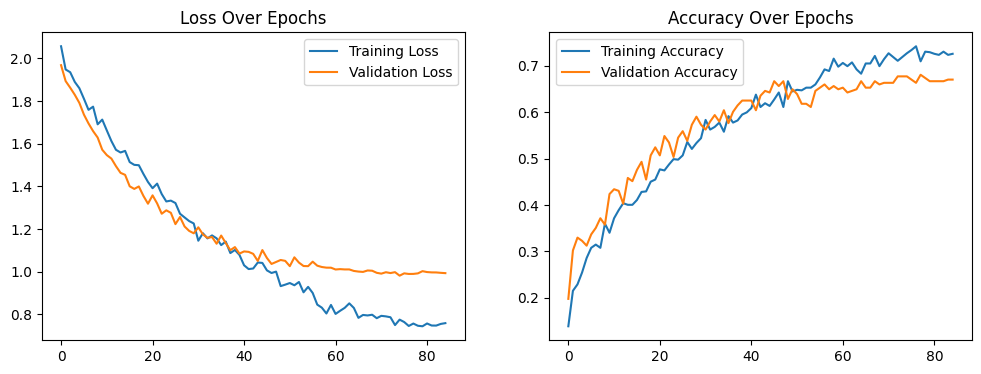

In [10]:
# Definición del modelo CNN
model_cnn = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(Y_train_categorical.shape[1], activation='softmax')  # Ajustar a la cantidad de categorías de emociones
])

# Compilación del modelo
model_cnn.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Configuración de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
)

# Configuración de ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    verbose=1, 
    min_lr=0.00001
)

# Entrenamiento del modelo
history = model_cnn.fit(
    X_train_scaled, Y_train_categorical,
    validation_data=(X_val_scaled, Y_val_categorical),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model_cnn.evaluate(X_test_scaled, Y_test_categorical)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

9/9 [==============================] - 0s 1ms/step


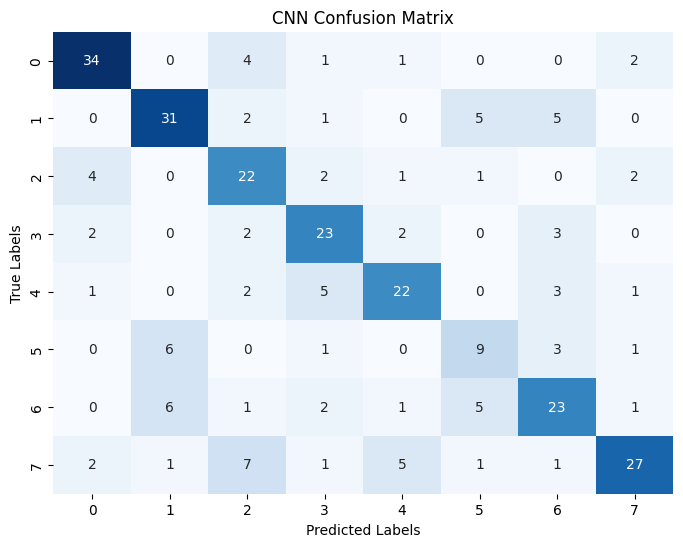

In [12]:
# Primero, obtenemos las predicciones del modelo como probabilidades
predictions = model_cnn.predict(X_test_scaled)

# Convertimos las probabilidades a etiquetas de clase (índices)
predicted_classes_indices = predictions.argmax(axis=1)

# Convertimos los índices de clase predichos a etiquetas de texto usando el inverso del LabelEncoder
predicted_labels = label_encoder.inverse_transform(predicted_classes_indices)

# Asumimos que 'Y_test' originalmente contenía las etiquetas en formato de texto
# Si 'Y_test' está en formato numérico o categórico, asegúrate de convertirlo a texto usando 'inverse_transform' del LabelEncoder
# Por simplicidad, asumimos que 'Y_test' ya está en el formato adecuado o lo convertimos aquí
Y_test_text = label_encoder.inverse_transform(Y_test_encoded)

# Calculamos la matriz de confusión usando las etiquetas verdaderas y las predichas
cnn_conf_matrix = confusion_matrix(Y_test_text, predicted_labels)

# Etiquetas para los ejes del heatmap
axis_labels = label_encoder.classes_

# Plotear la matriz de confusión para RandomForestClassifier
plot_confusion_matrix(cnn_conf_matrix, title='CNN Confusion Matrix')

#### 4.2. RFC

RandomForestClassifier - Mejor Score de Validación: 0.5335932248958194
RandomForestClassifier - Precisión en el Conjunto de Validación: 0.5868055555555556
RandomForestClassifier - Precisión en el Conjunto de Prueba: 0.6076388888888888


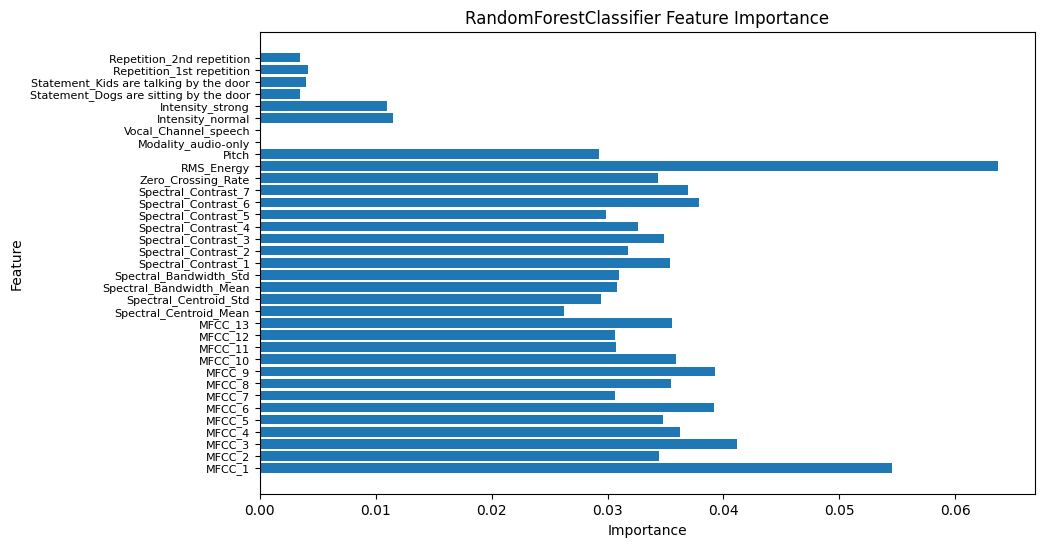

In [13]:
rf_classifier = RandomForestClassifier()

# Definir los parámetros a explorar para RandomForestClassifier
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizar GridSearchCV para RandomForestClassifier
rf_grid_search = GridSearchCV(rf_classifier, rf_params, cv=5) # verbose=2
rf_grid_search.fit(X_train_scaled.reshape(X_train_scaled.shape[0], -1), Y_train_encoded)

# Obtener los mejores modelos y sus puntajes de validación
best_rf_model = rf_grid_search.best_estimator_
best_rf_score = rf_grid_search.best_score_

# Realizar predicciones en el conjunto de validación y calcular la precisión
rf_val_preds = best_rf_model.predict(X_val_scaled.reshape(X_val_scaled.shape[0], -1))

rf_val_accuracy = accuracy_score(Y_val_encoded, rf_val_preds)


print("RandomForestClassifier - Mejor Score de Validación:", best_rf_score)
print("RandomForestClassifier - Precisión en el Conjunto de Validación:", rf_val_accuracy)

# Realizar predicciones en el conjunto de prueba usando los mejores modelos encontrados
rf_test_preds = best_rf_model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], -1))

# Calcular la precisión en el conjunto de prueba
rf_test_accuracy = accuracy_score(Y_test_encoded, rf_test_preds)

print("RandomForestClassifier - Precisión en el Conjunto de Prueba:", rf_test_accuracy)

# Obtener la importancia de las características para RandomForestClassifier
rf_feature_importance = best_rf_model.feature_importances_

# Crear nombres de características
feature_names = X_train.columns.tolist()

# Plotear Feature Importance para RandomForestClassifier
plt.figure(figsize=(10, 6))
plt.barh(feature_names, rf_feature_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(fontsize=8)
plt.title('RandomForestClassifier Feature Importance')
plt.show()

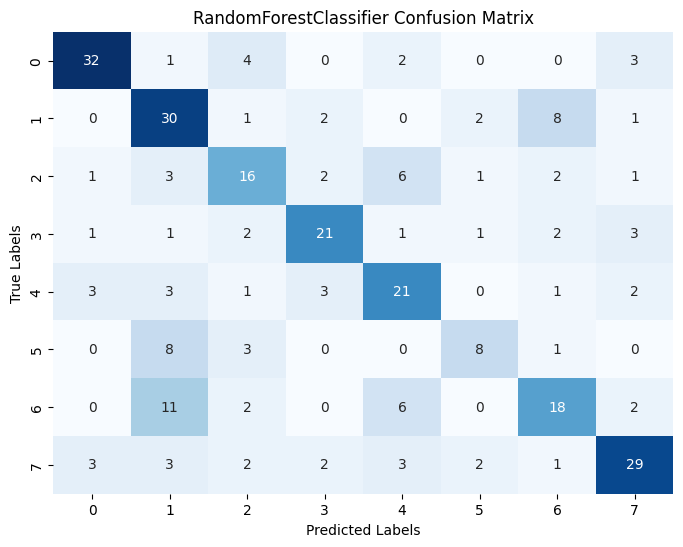

In [14]:
# Calcular la matriz de confusión para RandomForestClassifier
rf_conf_matrix = confusion_matrix(Y_test_encoded, rf_test_preds)

# Plotear la matriz de confusión para RandomForestClassifier
plot_confusion_matrix(rf_conf_matrix, title='RandomForestClassifier Confusion Matrix')

#### 4.3. SVM

SVM - Mejor Score de Validación: 0.5485750772953354
SVM - Precisión en el Conjunto de Validación: 0.5659722222222222
SVM - Precisión en el Conjunto de Prueba: 0.5798611111111112


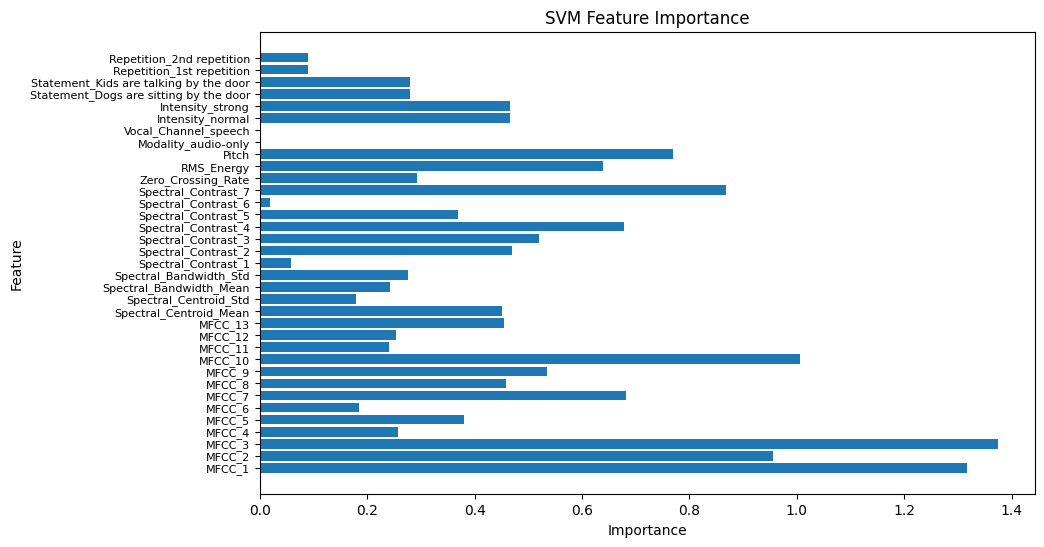

In [15]:
svm_classifier = SVC()

# Definir los parámetros a explorar para SVC
svm_params = {
    'kernel': ['linear'], # 'rbf'
    'C': [0.1, 1, 5, 10],
    'gamma': ['scale', 'auto']
}

# Realizar GridSearchCV para SVC
svm_grid_search = GridSearchCV(svm_classifier, svm_params, cv=5) # verbose=2
svm_grid_search.fit(X_train_scaled.reshape(X_train_scaled.shape[0], -1), Y_train_encoded)

# Obtener los mejores modelos y sus puntajes de validación
best_svm_model = svm_grid_search.best_estimator_
best_svm_score = svm_grid_search.best_score_

# Realizar predicciones en el conjunto de validación y calcular la precisión
svm_val_preds = best_svm_model.predict(X_val_scaled.reshape(X_val_scaled.shape[0], -1))

svm_val_accuracy = accuracy_score(Y_val_encoded, svm_val_preds)


print("SVM - Mejor Score de Validación:", best_svm_score)
print("SVM - Precisión en el Conjunto de Validación:", svm_val_accuracy)

# Realizar predicciones en el conjunto de prueba usando los mejores modelos encontrados
svm_test_preds = best_svm_model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], -1))

# Calcular la precisión en el conjunto de prueba
svm_test_accuracy = accuracy_score(Y_test_encoded, svm_test_preds)

print("SVM - Precisión en el Conjunto de Prueba:", svm_test_accuracy)

# Calcular la importancia de las características para SVC
svm_coefficients = best_svm_model.coef_[0]
svm_feature_importance = np.abs(svm_coefficients)

# Crear nombres de características
feature_names = X_train.columns.tolist()

# Plotear Feature Importance para SVC
plt.figure(figsize=(10, 6))
plt.barh(feature_names, svm_feature_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(fontsize=8)
plt.title('SVM Feature Importance')
plt.show()

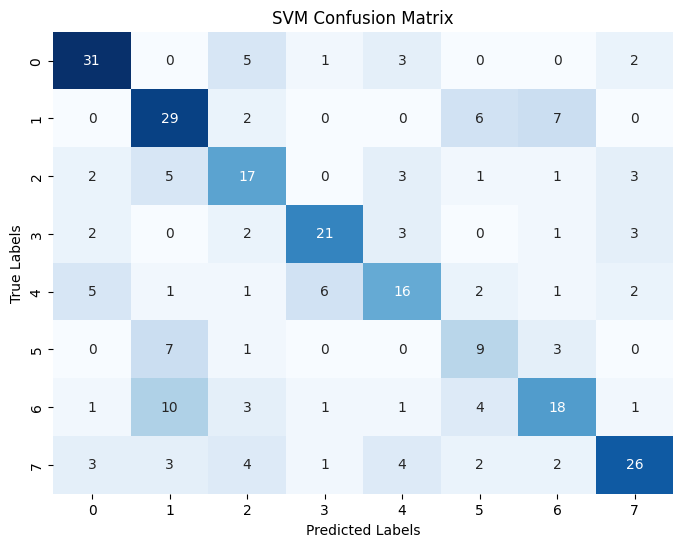

In [16]:
# Calcular la matriz de confusión para SVM
svm_conf_matrix = confusion_matrix(Y_test_encoded, svm_test_preds)

# Plotear la matriz de confusión para SVM
plot_confusion_matrix(svm_conf_matrix, title='SVM Confusion Matrix')

In [17]:
print("CNN test accuracy:", round(test_accuracy * 100, 2), "%")
print("RFC test accuracy:", round(rf_test_accuracy * 100, 2), "%") 
print("SVM test accuracy:", round(svm_test_accuracy * 100, 2), "%")

CNN test accuracy: 66.32 %
RFC test accuracy: 60.76 %
SVM test accuracy: 57.99 %


### 5. Conclusiones

1) en este escenario no se aplica Data Augmentation para mejorar la claridad del notebook pero si se empleó en un estudio previo y daba peores resultados debido a que el conjunto actual es pequeño, si se tuviese un conjunto de audios superior si mejoraría su aplicación. 

2) las capas LSTM empeora el accuracy: se estudió también pero se obtuvieron resultados peores que empleando las capas actuales. 

3) el mejor modelo ha sido el que emplea redes neuronales convolucionales, lo cuál no sorprende porque ya se había demostrado en varias competiciones que este modelo reinaba sobre el resto. 

4) los resultados no son malos, específicamente el de la CNN: la gran mayoría de trabajos de otras personas en esta competición consiguen peores resultados. 

### 6. Próximos pasos

1) aumentar el conjunto de datos para aplicar Data Augmentation y capas LSTM con el fin de obtener resultados mucho mejores que los actuales. 

2) realizar un mejor EDA + tratamiento y transformación de variables

3) crear un script .py dónde tú le pases un audio y te realice la predicción al momento (aplicar un set de datos multilingual y un modelo que se ajuste)

4) estudiar posibles implementaciones de IA